# Method Evaluation

-------




(1414, 2121, 3)


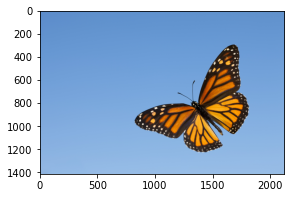

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
plt.rcParams["figure.figsize"] = (20,3)
import os
import fnmatch


img = imread('papillon.jpg')[:,:,:3]
img_rafale = imread('rafale.jpg')[:,:,:3]

gray = np.mean(img, axis = 2) # there exists other formulas to convert to gray but mean seems to work fine
print(img.shape)
plt.imshow(img)
plt.show()

##### This example is a simple case where the salient object can't be clearer to distinguish from the uniform background, the idea behind the algorithm should be most effective in this case

In [3]:
def spectralSaliency(img,width = 64, scale = None): #grayscale image
    #rescale image to lower resolution
    if scale is None:
        img = cv2.resize(img, (width,int(width*img.shape[0]/img.shape[1])))
    else:
        img = cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale)) )
    
    # apply discrete fourier transform on image 
    
    c = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)
    
    # compute magnitude  
    mag = np.sqrt(c[:,:,0]**2 + c[:,:,1]**2)
    
    # magnitude is passed through a 3*3 mean filter and compared to original magintude
    # we use log since our assumption concerns the shape of natural images' log magnitude shape (see article)
    spectralResidual = np.exp(np.log(mag) - cv2.boxFilter(np.log(mag), -1, (3,3)))

    #we reconstruct the image weighted by residual
    c[:,:,0] = c[:,:,0] * spectralResidual / mag
    c[:,:,1] = c[:,:,1] * spectralResidual / mag
    c = cv2.dft(c, flags = (cv2.DFT_INVERSE | cv2.DFT_SCALE))
    saliency_map = c[:,:,0]**2 + c[:,:,1]**2
    # we apply a gaussian filter for smoothing
    saliency_map = cv2.normalize(cv2.GaussianBlur(saliency_map,(9,9),3,3), saliency_map, 0., 1., cv2.NORM_MINMAX)
    return np.float32(saliency_map)
    

In [44]:
def predict(img,width):
    cutoff = 3
    gray = np.mean(img,axis = 2)
    s_map = spectralSaliency(gray,width=width)
    rs_map = resize(image=s_map, output_shape=gray.shape) # resized saliency map
    rs_map = (rs_map > cutoff * rs_map.mean()) * 1
    return rs_map

def MAE(prediction,ground_truth):
    return np.mean(np.abs(prediction - ground_truth/255))
def precision(prediction,ground_truth):
    FP = ( (prediction - ground_truth) > 0) * 1  #predict 1 but actual 0
    TP = prediction * ground_truth #predict 1 and actual 1 
    return np.sum(FP)/(np.sum(FP) + np.sum(TP))
def recall(prediction,ground_truth):
    TP = prediction * ground_truth #predict 1 and actual 1 
    AP = ground_truth # all actual 1 
    return np.sum(TP)/np.sum(AP)
def f1_score(prediction,ground_truth):
    p = precision(prediction,ground_truth)
    r = recall(prediction,ground_truth)
    if p * r == 0:
        return 0
    return (p*r)/(p + r)
    
    

In [31]:
import tqdm
import pandas as pd

In [33]:
img_folder = "./DUT-OMRON-image/"
gt_folder = "./pixelwiseGT-new-PNG/"
score_dict = {}
width = 64
files_list = os.listdir(img_folder)[:500]
for file in tqdm.tqdm(files_list):
    if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
        filename = file.split('.')[0]
        try:
            im = imread(img_folder + filename + ".jpg")[:,:,:3] # no need for alpha channel 
            gt = imread(gt_folder + filename + ".png")
            rs_map = predict(im,width)
            #print(im.shape,gt.shape, rs_map.shape)
            mae = MAE(prediction=rs_map, ground_truth=gt)
            f1 = f1_score(prediction=rs_map, ground_truth=gt)
            score_dict[filename] = {"MAE": mae, "F1": f1}
        except Exception as e:
            print(e)
            print(filename)
            continue
            


  4%|███▍                                                                             | 21/500 [00:00<00:07, 64.59it/s]C:\Users\TheMatrix\anaconda3\envs\LAB_3.7\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 64.78it/s]


In [34]:
score_df = pd.DataFrame.from_dict(score_dict, orient = "index", columns=["MAE", "F1"]).reset_index().rename(columns={"index": "img_name"})
score_df.head(3)

,img_name,MAE,F1
0,im005,0.100851,0.000916
1,im010,0.076000,0.001436
2,im013,0.084013,0.003756


In [36]:
score_df.describe()

,MAE,F1
count,500.000000,481.000000
mean,0.158372,0.007004
std,0.110542,0.014444
min,0.011574,0.000000
25%,0.074932,0.000350
50%,0.128885,0.002648
75%,0.215169,0.007291
max,0.654067,0.130255


#### mean MAE on this dataset is 0.14

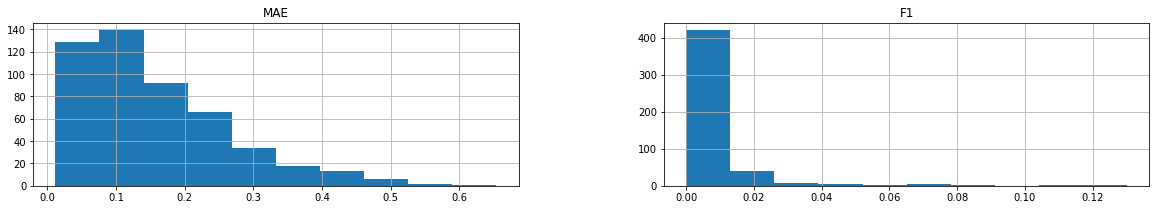

In [37]:
score_df.hist(bins = 10)
plt.show()

### some good cases:

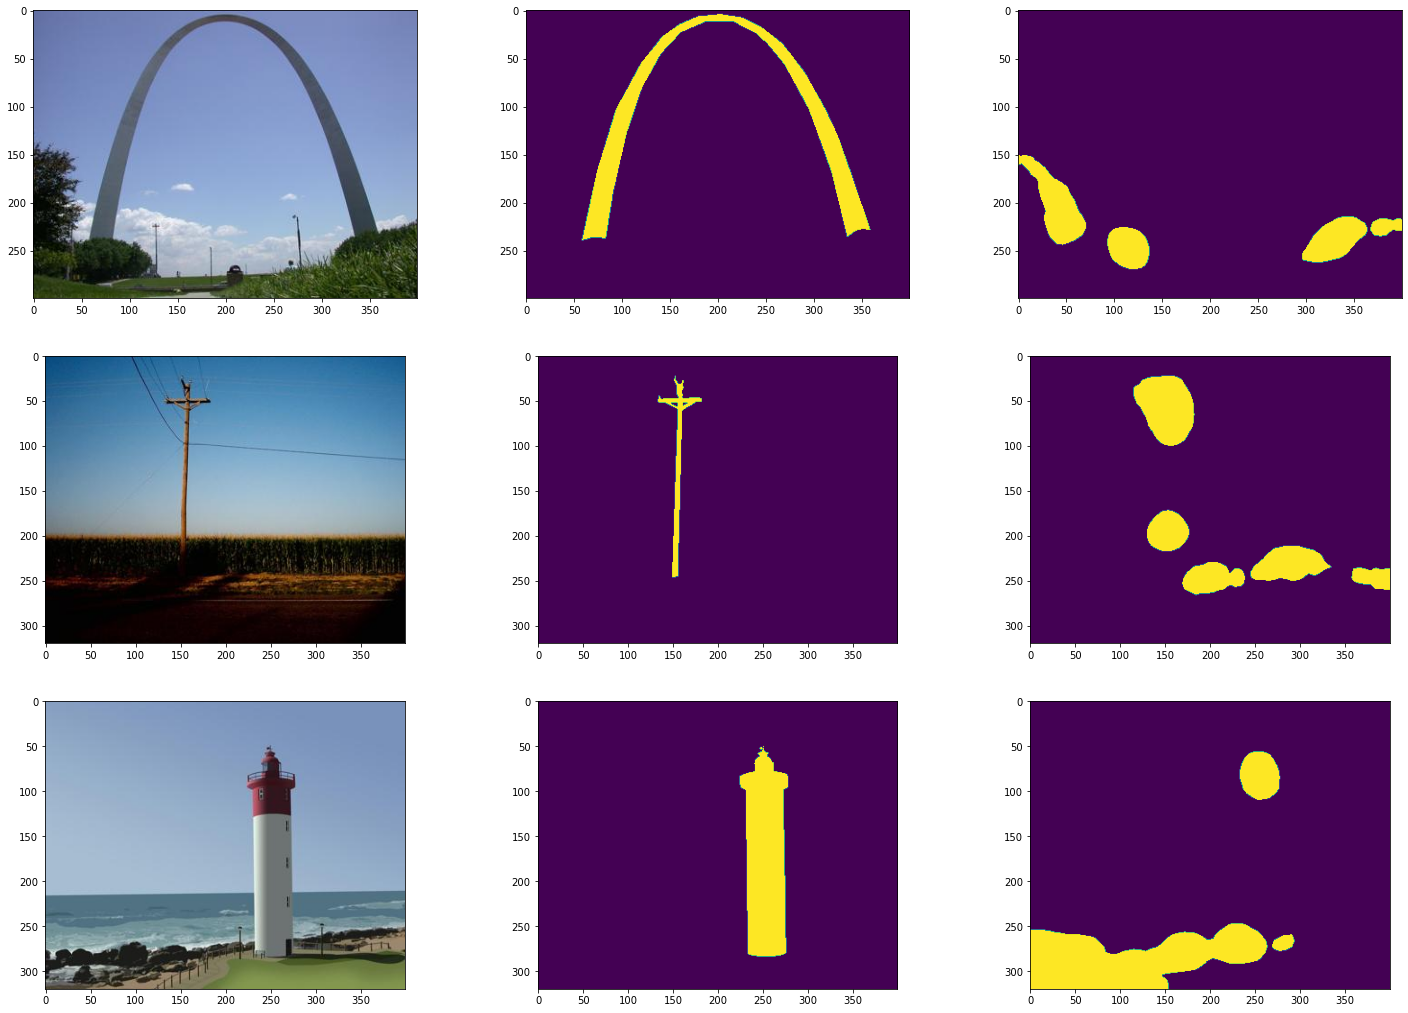

In [39]:
good_sample = score_df[score_df.F1 > score_df.F1.quantile(0.90)].sample(3)
plt.figure(figsize=(25,18))
for i in range(len(good_sample)):
    im_name = good_sample.iloc[i].img_name
    im_ = imread(img_folder + im_name + ".jpg")
    gt_ = imread(gt_folder + im_name + ".png")
    prediction_ = predict(im_,width)
    plt.subplot(len(good_sample),3,3*i+1)
    plt.imshow(im_)
    plt.subplot(len(good_sample),3,3*i+2)
    plt.imshow(gt_)
    plt.subplot(len(good_sample),3,3*i+3)
    plt.imshow(prediction_)
plt.show()

### some bad cases:

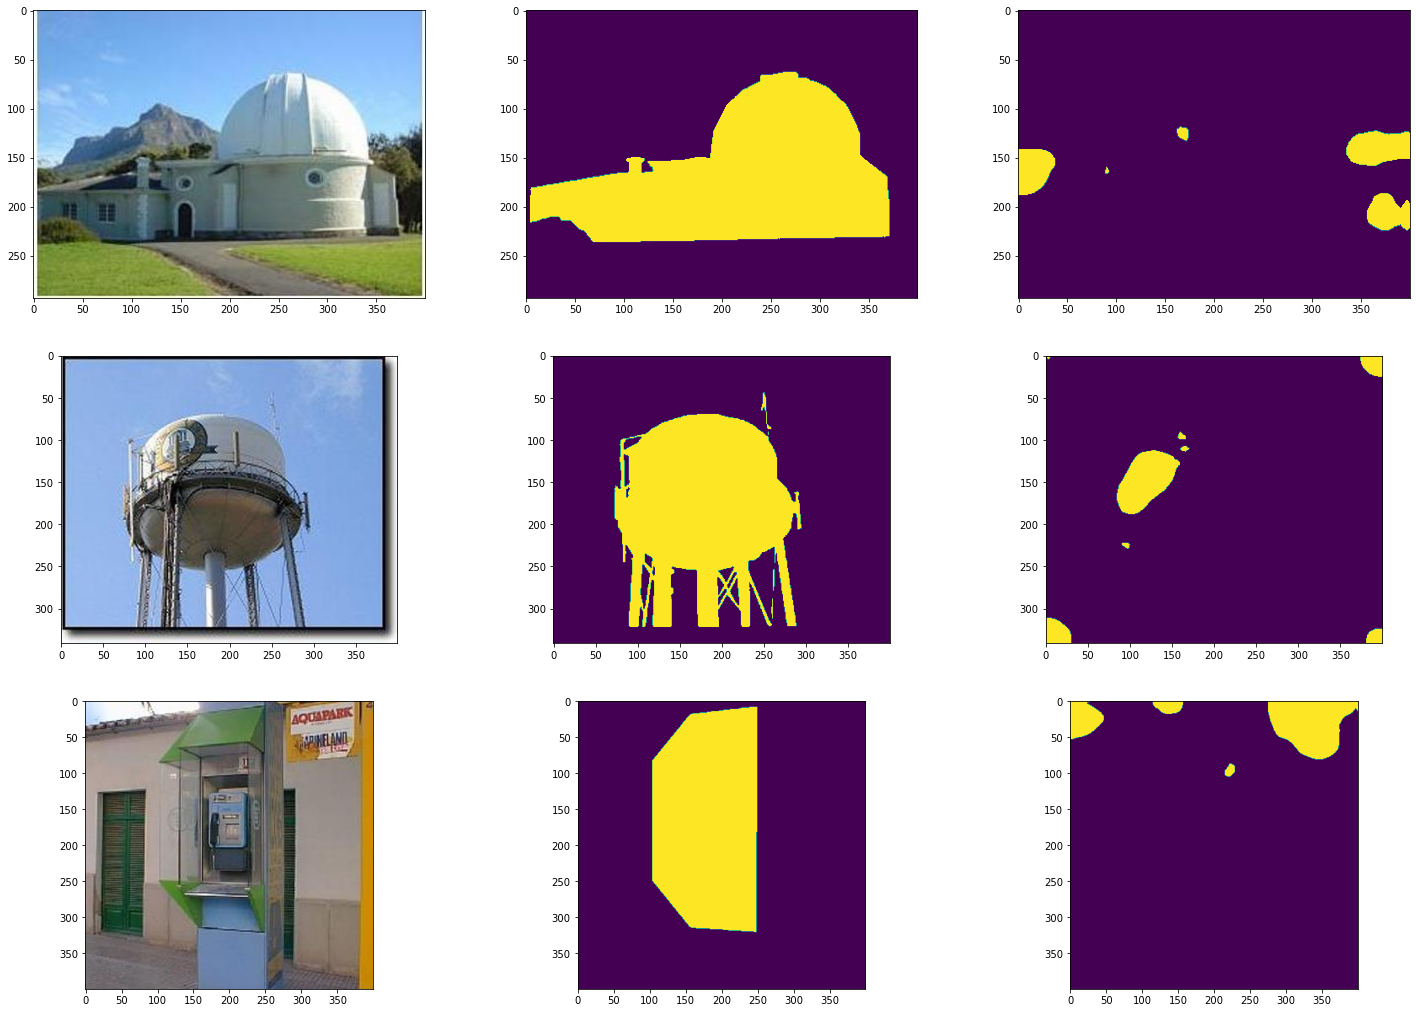

In [40]:
bad_sample = score_df[score_df.MAE > score_df.MAE.quantile(0.80)].sample(3)
plt.figure(figsize=(25,18))
for i in range(len(bad_sample)):
    im_name = bad_sample.iloc[i].img_name
    im_ = imread(img_folder + im_name + ".jpg")
    gt_ = imread(gt_folder + im_name + ".png")
    prediction_ = predict(im_,width)
    plt.subplot(len(bad_sample),3,3*i+1)
    plt.imshow(im_)
    plt.subplot(len(bad_sample),3,3*i+2)
    plt.imshow(gt_)
    plt.subplot(len(bad_sample),3,3*i+3)
    plt.imshow(prediction_)
plt.show()

# Analyze impact of width

In [45]:
def compare_width(im,gt,score_dict):
    widths = [i* 16 for i in range(1,16)]
    im_size = im.size
    for w in widths:
        rs_map = predict(im,w)
        #print(im.shape,gt.shape, rs_map.shape)
        mae = MAE(prediction=rs_map, ground_truth=gt)
        f1 = f1_score(prediction=rs_map, ground_truth=gt)
        score_dict[filename + "_" + str(w)] = {"size": im_size,"width":w,"MAE": mae, "F1": f1}
score_dict = {}
files_list = os.listdir(img_folder)[:500]
for file in tqdm.tqdm(files_list):
    if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
        filename = file.split('.')[0]
        try:
            im = imread(img_folder + filename + ".jpg")[:,:,:3] # no need for alpha channel 
            gt = imread(gt_folder + filename + ".png")
            compare_width(im,gt,score_dict)
        except Exception as e:
            print(e)
            print(filename)
            continue

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\TheMatrix\anaconda3\envs\LAB_3.7\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.87it/s]


In [46]:
score_df = pd.DataFrame.from_dict(score_dict, orient = "index", columns=["size","width","MAE", "F1"]).reset_index().rename(columns={"index": "img_name"})
score_df.head(3)

,img_name,size,width,MAE,F1
0,im00516,394800,16,0.114240,NaN
1,im00532,394800,32,0.114240,NaN
2,im00548,394800,48,0.100638,0.001309


In [48]:
score_df.groupby("width").mean()

,size,MAE,F1
width,,,
16,360403.938,0.153438,0.001636
32,360403.938,0.153396,0.003923
48,360403.938,0.155586,0.004904
64,360403.938,0.158372,0.007004
80,360403.938,0.159993,0.007602
96,360403.938,0.161723,0.009352
112,360403.938,0.163666,0.010048
128,360403.938,0.165397,0.010797
144,360403.938,0.166640,0.011015
